In [1]:
import os
import sys
import time

#import ariadne.graph_net.model
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_40165/1187170015.py:13: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display
/tmp/ipykernel_40165/1187170015.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output, display


In [3]:
from ariadne.graph_net.graph_utils.graph import load_graph

In [4]:
!ls /zfs/store5.hydra.local/user/p/pgonchar/data/bmn/run7/events/

simdata_ArPb_3.2AGeV_mb_10.txt	simdata_ArPb_3.2AGeV_mb_31.txt
simdata_ArPb_3.2AGeV_mb_11.txt	simdata_ArPb_3.2AGeV_mb_32.txt
simdata_ArPb_3.2AGeV_mb_12.txt	simdata_ArPb_3.2AGeV_mb_33.txt
simdata_ArPb_3.2AGeV_mb_13.txt	simdata_ArPb_3.2AGeV_mb_34.txt
simdata_ArPb_3.2AGeV_mb_14.txt	simdata_ArPb_3.2AGeV_mb_35.txt
simdata_ArPb_3.2AGeV_mb_16.txt	simdata_ArPb_3.2AGeV_mb_36.txt
simdata_ArPb_3.2AGeV_mb_17.txt	simdata_ArPb_3.2AGeV_mb_37.txt
simdata_ArPb_3.2AGeV_mb_18.txt	simdata_ArPb_3.2AGeV_mb_38.txt
simdata_ArPb_3.2AGeV_mb_19.txt	simdata_ArPb_3.2AGeV_mb_39.txt
simdata_ArPb_3.2AGeV_mb_1.txt	simdata_ArPb_3.2AGeV_mb_3.txt
simdata_ArPb_3.2AGeV_mb_20.txt	simdata_ArPb_3.2AGeV_mb_40.txt
simdata_ArPb_3.2AGeV_mb_21.txt	simdata_ArPb_3.2AGeV_mb_42.txt
simdata_ArPb_3.2AGeV_mb_22.txt	simdata_ArPb_3.2AGeV_mb_43.txt
simdata_ArPb_3.2AGeV_mb_23.txt	simdata_ArPb_3.2AGeV_mb_44.txt
simdata_ArPb_3.2AGeV_mb_24.txt	simdata_ArPb_3.2AGeV_mb_45.txt
simdata_ArPb_3.2AGeV_mb_25.txt	simdata_ArPb_3.2AGeV_mb_46.txt
simdata_Ar

In [5]:
!pwd

/zfs/store5.hydra.local/user/d/drusov/ariadne/notebooks


In [6]:
!nvidia-smi

Sun Aug 28 13:39:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |  28903MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [8]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
    
from eval.event_evaluation import EventEvaluator
from ariadne_v2.transformations import Compose, DropShort, DropTracksWithHoles, DropSpinningTracks, BakeStationValues, ConstraintsNormalize, FixStationsBMN, ToCylindrical
from ariadne.utils.model import get_checkpoint_path, weights_update

z_values = {0:12.344, 1: 15.614, 2: 24.499, 3: 39.702, 4: 64.535, 5: 112.649, 6: 135.330,7: 160.6635, 8: 183.668}
constraints = {'x': [-81.1348, 86.1815], 'y': [-27.17125, 38.90473], 'z': [11.97, 183.82]}
constraints_cylindrical = {'r': [0, (constraints['x'][1]**2 + constraints['y'][1]**2)**0.5],
                           'phi': [-3.15, 3.15],
                           'z': constraints['z']}

In [9]:
import scripts.clean_cache

#to clean cache if needed
#scripts.clean_cache.clean_jit_cache('20w')

## Tracknet

In [12]:
import torch
import faiss

NUM_POINTS_TO_SEARCH = 2

from ariadne_v2.inference import IModelLoader
from ariadne.tracknet_v2.model import TrackNETv2
class TrackNetModelLoader(IModelLoader):    
    def __call__(self):
        tracknet_input_features=3
        tracknet_conv_features=32
        
        tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne/lightning_logs/TrackNETv2',
                                   'version': 'version_47', 'checkpoint': 'latest'}
                                   #'version': 'OnlyRNN_alpha0.01_unbalanced', 'checkpoint': 'latest'}
        path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)

        model_tr = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True,
                                        use_causalconv=False,
                                        use_rnn=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
        model_tr.eval()
        model_tr.to(DEVICE)

        from ariadne.graph_net.model import GraphNet_v1

        gin.bind_parameter('GraphNet_v1.input_dim', 3)
        gin.bind_parameter('GraphNet_v1.hidden_dim', 128)
        gin.bind_parameter('GraphNet_v1.n_iters', 4)

        def weights_update_g(model, checkpoint):
            model_dict = model.state_dict()
            pretrained_dict =  checkpoint['state_dict']
            real_dict = {}
            for (k,v) in model_dict.items():
                needed_key = None
                for pretr_key in pretrained_dict:
                    if k in pretr_key:
                        needed_key = pretr_key
                        break
                assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
                real_dict[k] = pretrained_dict[needed_key]

            model.load_state_dict(real_dict)
            model.eval()
            return model

        graphnet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne/lightning_logs/GraphNet_v1',
                                    'version': 'version_55', 'checkpoint': 'latest'}
        path_g = get_checkpoint_path(**graphnet_ckpt_path_dict)

        #checkpoint_g = torch.load(path_g, map_location=torch.device('cpu'))
        checkpoint_g = torch.load(path_g, map_location=torch.device(DEVICE))
        model_g = weights_update_g(model=GraphNet_v1(),
                                   checkpoint=checkpoint_g)
        model_g.eval()
        model_g.to(DEVICE)

        model_hash = {
            "tracknet_ckpt_path_dict":path_to_tracknet_ckpt,
            'gin':gin.config_str(), 
            'model': '%r' % model_tr,
            'NUM_POINTS_TO_SEARCH':NUM_POINTS_TO_SEARCH
        }
        return model_hash, [model_tr, model_g]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
import ariadne.transformations  as trn

tracknet_transformer = trn.Compose([
    #trn.DropShort(num_stations=4),
    #trn.DropTracksWithHoles(),
    #trn.DropSpinningTracks(),
    #trn.BakeStationValues(values=z_values),
    #trn.ConstraintsNormalize(constraints=constraints),
    #trn.ToCylindrical()
    ]
)

graphnet_transformer = trn.Compose([

])

COLS = ['x', 'y', 'z']

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont)

def build_hits(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return cont

def preprocess_one_event(event_df, n_neighbours=5):
    try:
        tracknet_data = tracknet_transformer(event_df)
    except AssertionError as err:
        #print("ASS error %r" % err)
        return None
    return (tracknet_data, 1)

times = []

res_1 = None

from ariadne.graph_net.dataset import collate_fn

def run_tracknet_eval(result_from_prev_step, model, n_neighbours=NUM_POINTS_TO_SEARCH):

    with torch.no_grad():
        #preds, labels, ellipses = go_over_stations(result_from_prev_step[0].query('not det.isna()'), model[0], n_neighbours)
        preds, labels, ellipses = go_over_stations(result_from_prev_step[0], model[0], n_neighbours)

    result, new_eventdf = build_df(preds, labels, result_from_prev_step[0])
    for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
        result[col] = result[col].astype(int)
    if len(result) == 0:
        return result
    
    if only_tracknet:
        return result
        for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
            result[col] = result[col].apply(lambda x: -1 if x > result_from_prev_step[0].index_old.max() else x)
        result['len'] = N_STATIONS - np.argmax(np.fliplr(result[STATION_COLUMNS] >= 0), axis=1)
        return result.query('len > 3')

    #res_1.append(tracknet_event_to_reverse_graph(result_from_prev_step[0], result))

    graph, tracks = tracknet_event_to_graph(new_eventdf, result)
    graphs.append(graph)
    graphs.append(new_eventdf)
    graphs.append(tracks)
   # print(len(new_eventdf))
    #for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
    #    result[col] = result[col].apply(lambda x: -1 if x > result_from_prev_step[0].index_old.max() else x)
    #return result
    #X, Ri, Ro, y = graph
    #draw_single(X, Ri, Ro, y, c_true=(0, 1, 0, 1), c_fake=(1,0,0,0.5), xcord1=(0, 'x'), xcord2=(1, 'y'), ycord=(2, 'z'))
    batch_input, batch_target = collate_fn([graph])
    batch_input['inputs'] = [item.to(DEVICE) for item in batch_input['inputs']]

    with torch.no_grad():
        y_pred = model[1](batch_input['inputs']).cpu().numpy().flatten()
    #global res_1
    #res_1 = y_pred
    #y_pred = graph.y

    preds_y = [list(y_pred[track]) for track in tracks]
    classes = [np.array(pred).sum() > 0.7 * len(pred) for pred in preds_y]
    #classes = [(np.array(pred) > 0.5).all() for pred in preds_y] # each edge needs to achieve > 0.5

    result.track_pred = classes
    #result = result[classes]
    
    for col in [f'hit_id_{i}' for i in range(N_STATIONS)]:
        result[col] = result[col].apply(lambda x: -1 if x > result_from_prev_step[0].index_old.max() else x)
    return result

cuda


In [13]:
from ariadne.utils.base import store_in_index,search_in_index

In [14]:
def go_over_stations(df, model, n_neighbours, max_n_stations=9):
    max_batch_size = 256
    all_hits_index = build_index(df)
    tracks_vs_len, all_tracks, multiplicity = get_tracks(df)
    #print(tracks_vs_len)
    #seeds, target = to_cart(df)
    chunk_data_x = get_seeds_only_first_station(df)
    #print(chunk_data_x)
    #chunk_data_x = np.expand_dims(chunk_data_x, 1)
    #index = build_index(target)
    # search(target[:2], index)
    #chunk_data_x = seeds_to_input(seeds)
    chunk_data_len = torch.tensor(np.full(len(chunk_data_x), 1), dtype=torch.int64).to(DEVICE)
    chunk_data_mask = np.ones((len(chunk_data_x), 1, 1), dtype=bool)
    gru_candidates = []
    x_candidates = []
    candidate_labels = []
    candidate_ellipses = []
    for stations_gone in range(1, max_n_stations):
        #print(f'===> {stations_gone}')
        num_batches = int(len(chunk_data_x) / max_batch_size) + 1
        #print(num_batches)
        num_right_batches = 0
        num_all_batches = 0
        next_stage_xs = []
        next_stage_lens = []
        next_stage_mask = []
        if len(chunk_data_x) == 0:
            #print('Have zero ellipces on this station! Skipping other stations')
            #print(candidate_ellipses)
            #print(x_candidates)
            #print(candidate_labels)
            return x_candidates, candidate_labels, candidate_ellipses
        labels_for_empty_el_batch = []
        labels_for_full_el_batch = []
        station_df = df[df['station']==stations_gone]
        current_index = build_index(station_df)
        this_station_hits = build_hits(station_df)
        for batch_num in range(num_batches):
            min_i = max_batch_size*batch_num
            max_i = min(max_batch_size + min_i, len(chunk_data_x))
            if min_i==max_i:
                #print('Have zero ellipces on this station! Skipping other stations')
                #print(candidate_ellipses)
                #print(x_candidates)
                #print(candidate_labels)
                return x_candidates, candidate_labels, candidate_ellipses

            this_batch_x = torch.tensor(chunk_data_x[min_i: max_i]).to(DEVICE)
            this_batch_len = chunk_data_len[min_i: max_i]
            this_batch_mask = chunk_data_mask[min_i:max_i]

            batch_prediction, batch_gru = model(this_batch_x.float(),
                                                     torch.tensor(this_batch_len, dtype=torch.int64).to(DEVICE),
                                                     return_gru_states=True)

            new_pred = torch.full((len(batch_prediction), 5), z_values_norm_dict[stations_gone], device=DEVICE)
            new_pred[:, :2] = batch_prediction[:, -1, :2]
            new_pred[:, 3:] = batch_prediction[:, -1, 2:]
            batch_prediction = new_pred
            batch_gru = batch_gru[:, -1]
            
            prediction_numpy = batch_prediction.detach().cpu().numpy()
            
            #print(mask)
            #print(model(new_x,
            #            torch.tensor(this_batch_len + 1, dtype=torch.int64).to(DEVICE),
            #            mask,
            #            return_x=True))

            #if batch_num == 0:
              #  print(f'station {stations_gone+1}, on this station: {len(this_station_hits)} hits' )
            if len(this_station_hits) == 0:
            #    LOGGER.info('Have zero hits on this station! Skipping other stations')
            #    print(candidate_ellipses)
            #    print(x_candidates)
            #    print(candidate_labels)
                return x_candidates, candidate_labels, candidate_ellipses

            dists, nearest_hits_index = search_distance(prediction_numpy[:, :3],
                                                 current_index, 
                                                 n_neighbours,
                                                 n_dim=3)

            nearest_hits = this_station_hits[nearest_hits_index]
            nearest_hits, in_ellipse_mask = filter_hits_in_ellipses(prediction_numpy,
                                                               nearest_hits,
                                                               nearest_hits_index,
                                                               filter_station=False,
                                                               z_last=True,
                                                               find_n=nearest_hits_index.shape[1])
            res_1.append(dists[in_ellipse_mask])
            nearest_hits = torch.from_numpy(nearest_hits)
            nearest_hits_mask = in_ellipse_mask
            # here empty ellipses and all inputs for them are saved
            empty_xs, empty_ellipses, empty_grus, predicted_ellipses = get_data_for_empty_ellipses(this_batch_x, 
                                                                               batch_prediction, 
                                                                               batch_gru, 
                                                                               nearest_hits_mask)
            prolonged_batch_xs, prolonged_grus, prolonged_virt_mask = prolong(this_batch_x,
                                                         batch_gru,
                                                         nearest_hits_mask,
                                                         nearest_hits,
                                                         stations_gone,
                                                         this_batch_mask,
                                                         use_torch=True)
            next_stage_xs.append(prolonged_batch_xs)
            next_stage_lens.append(np.full(len(prolonged_batch_xs), stations_gone + 1))
            next_stage_mask.append(prolonged_virt_mask)
            
            
            if add_virtual:
                num_virtuals = (~this_batch_mask).sum(axis=1).flatten()
                
                new_x = torch.zeros((this_batch_x.shape[0], stations_gone + 1, 3), dtype=float)
                new_x[:, :-1] = this_batch_x
                new_x[:, -1] = batch_prediction[:, :3]
                
                #thresh = 0#0.0003
                #print(dists[:, 0])
                
                new_x = new_x[(num_virtuals < max_virtuals) & (dists[:, 0] >= thresh)]
                new_mask = this_batch_mask[(num_virtuals < max_virtuals) & (dists[:, 0] >= thresh)]
               
                
                '''
                new_x[:, -1, 2] = z_values_norm_dict[stations_gone]
                #print('new_x')
                #print(new_x)
                #print('batch_prediction')
                #print(batch_prediction)
                mask = torch.ones(max_i - min_i, stations_gone + 1)
                mask[:, -1] = False
                virtual_cands = model(new_x,
                                    torch.tensor(this_batch_len + 1, dtype=torch.int64).to(DEVICE),
                                    mask,
                                    return_x=True)
                '''
                next_stage_xs.append(new_x)
                next_stage_lens.append(np.full(len(new_x), stations_gone + 1))
                next_stage_mask.append(np.append(new_mask, np.zeros((len(new_x), 1, 1), dtype=bool), axis=1))

            if stations_gone > 3:
                use_empty_ellipses = []
                empty_ellipses_station_intersections = []
                use_empty_ellipses = torch.ones(len(empty_ellipses), dtype=torch.bool)
                empty_xs = empty_xs[use_empty_ellipses]
                empty_grus = empty_grus[use_empty_ellipses]
                if len(empty_xs) > 0:
                    (candidate_labels,
                     labels_for_empty_el_batch,
                     gru_candidates,
                     x_candidates,
                     candidate_ellipses) =  get_candidates(empty_xs, 
                                                     tracks_vs_len[stations_gone],
                                                     prolonged_grus[:, -2], 
                                                     empty_ellipses,
                                                     all_hits_index,
                                                     candidate_labels, 
                                                     labels_for_full_el_batch, 
                                                     gru_candidates, 
                                                     x_candidates,
                                                     candidate_ellipses)
                    #print(candidate_ellipses)
            if (stations_gone == (max_n_stations-1)): # if we are predicting for last station
                if len(prolonged_batch_xs) > 0:  # now we prolong candidates with all hits *in* ellipses
                    (candidate_labels,
                     labels_for_full_el_batch, 
                     gru_candidates, 
                     x_candidates,
                     candidate_ellipses) =  get_candidates(prolonged_batch_xs, 
                                                     tracks_vs_len[stations_gone + 1],
                                                     prolonged_grus[:, -1], 
                                                     predicted_ellipses,
                                                     all_hits_index,
                                                     candidate_labels, 
                                                     labels_for_full_el_batch, 
                                                     gru_candidates, 
                                                     x_candidates,
                                                     candidate_ellipses)

        if len(next_stage_xs) > 1:
            chunk_data_x = np.concatenate(next_stage_xs, 0)
            chunk_data_len = np.concatenate(next_stage_lens, 0)
            chunk_data_mask = np.concatenate(next_stage_mask, 0)
        else:
            try:
                chunk_data_x = next_stage_xs[0]
                chunk_data_len = next_stage_lens[0]
                chunk_data_mask = next_stage_mask[0]
            except:
                continue
    return x_candidates, candidate_labels, candidate_ellipses

def get_tracks(df, min_len=4):
    tracks = df[df['track'] != -1].groupby('track')
    multiplicity = tracks.ngroups
    tracks_vs_len = {3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    all_tracks = []
    for i, track in tracks:
        temp_track = track[['x', 'y', 'z']].values
        if len(temp_track) >= min_len:
            tracks_vs_len[len(temp_track)].append(temp_track)
            all_tracks.append(temp_track)
    for stations_in_track, this_track_list in tracks_vs_len.items():
        if len(this_track_list) > 0:
            tracks_vs_len[stations_in_track] = np.stack(this_track_list, 0)
    return tracks_vs_len, all_tracks, multiplicity

def get_seeds_only_first_station(df, columns=['x','y','z']):
    real = df#[df['track']!=-1]
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    # all possible combinations
    seeds = np.zeros((len(temp1), 1, 3))
    seeds[:, 0, ] = st0_hits
    return seeds

def filter_hits_in_ellipses(ellipses, nearest_hits, hits_index, z_last=True, filter_station=True, find_n=10):
    """Function to get hits, which are in given ellipse.
    Space is 3-dimentional, so either first component of ellipce must be z-coordinate or third.
    Ellipse semiaxises must include x- and y-axis.
    Arguments:
        ellipse (np.array of size 5): predicted index with z-component like
                                      (x,y,z, x-semiaxis, y_semiaxis) or (z, x,y, x-semiaxis, y_semiaxis)
        nearest_hits (np.array of shape (n_hits, 3) or only 3): some hits in 3-dim space
        z_last (bool): If True, first component of vector is interpreted as z, if other, third.
        filter_station (bool): if True, only hits with same z-coordinate are considered, else all hits
    Returns:
        numpy.ndarry with filtered hits, all of them in given ellipse, sorted by increasing of distance
    """
    assert nearest_hits.shape[-1] == 3, "index is 3-dimentional, please add z-coordinate to centers"
    if nearest_hits.ndim < 2:
        nearest_hits = np.expand_dims(nearest_hits, 0)
    if nearest_hits.ndim < 3:
        nearest_hits = np.expand_dims(nearest_hits, 0)
    assert ellipses.shape[-1] == 5, "index is 3-dimentional, you need to provide z-coordinate (z_c, x_c, y_c, x_r, y_r) or (x_c, y_c, z_c, x_r, y_r)"
    #ellipses = np.expand_dims(ellipses, -1)
    #find_n = len(nearest_hits)
    ellipses = np.expand_dims(ellipses, 2)
    #found_hits = nearest_hits.reshape(-1, find_n, nearest_hits.shape[-1])
    if z_last:
        x_part = (ellipses[:,0].repeat(find_n,1) - nearest_hits[:, :, 0]) / ellipses[:, 3].repeat(find_n,1)
        #print(x_part**2)
        y_part = (ellipses[:,1].repeat(find_n,1) - nearest_hits[:, :, 1]) / ellipses[:, 4].repeat(find_n,1)
        #print(y_part**2)
    else:
        x_part = (nearest_hits[:, :, 1] - ellipses[:, 1].repeat(find_n, 1)) / ellipses[:, -2].repeat(find_n, 1)
        y_part = (nearest_hits[:, :, 2] - ellipses[:, 2].repeat(find_n, 1)) / ellipses[:, -1].repeat(find_n, 1)
    left_side = x_part**2 + y_part**2
    is_in_ellipse = left_side <= 1
    is_in_ellipse *= hits_index != -1
    return nearest_hits, is_in_ellipse

def get_data_for_empty_ellipses(x, preds, grus, mask):
    empty_ellipses_mask = (mask.sum(axis=-1) == 0) # if nothing is found in ellipse
    empty_ellipses = preds[empty_ellipses_mask]#.detach().cpu().numpy()
    full_ellipses = preds[~empty_ellipses_mask]
    empty_xs = x[empty_ellipses_mask]
    empty_grus = grus[empty_ellipses_mask]#.detach().cpu().numpy()
    return empty_xs, empty_ellipses, empty_grus, full_ellipses

def prolong(x, gru, nearest_hits_mask, nearest_hits, stations_gone, virtual_mask, use_torch=False):
    if use_torch:
        xs_for_prolong = x.unsqueeze(1).repeat((1, nearest_hits_mask.shape[-1], 1,1))
        grus_for_prolong = gru.unsqueeze(1)
        grus_for_prolong = grus_for_prolong.repeat((1, nearest_hits_mask.shape[-1], 1))
        #virt_mask_for_prolong = np.expand_dims(virtual_mask, 1).repeat(nearest_hits_mask.shape[-1], 1)

        virt_mask_for_prolong = np.tile(np.expand_dims(virtual_mask, axis=1), (1, nearest_hits_mask.shape[-1], 1, 1))

        prolonged_xs = torch.zeros((len(xs_for_prolong),
                                    nearest_hits_mask.shape[-1],
                                    xs_for_prolong.shape[-2] + 1,
                                    xs_for_prolong.shape[-1]))
        prolonged_xs[:, :, :xs_for_prolong.shape[-2], :] = xs_for_prolong
        prolonged_xs[:, :, xs_for_prolong.shape[-2], :] = nearest_hits
        prolonged_xs = prolonged_xs.reshape(-1, stations_gone + 1, 3)
        
        prolonged_virt_mask = np.ones((len(xs_for_prolong),
                                    nearest_hits_mask.shape[-1],
                                    stations_gone + 1,
                                    1))
        prolonged_virt_mask[:, :, :stations_gone] = virt_mask_for_prolong
        prolonged_virt_mask = prolonged_virt_mask.reshape(-1, stations_gone + 1, 1)
        
        nearest_hits_mask = nearest_hits_mask.reshape(-1)
        
        prolonged_virt_mask = prolonged_virt_mask[nearest_hits_mask].astype(bool)
        
        prolonged_xs = prolonged_xs[nearest_hits_mask]
        prolonged_grus = grus_for_prolong.reshape(-1, grus_for_prolong.shape[-1])
        prolonged_grus = prolonged_grus[nearest_hits_mask]
    else:
        xs_for_prolong = np.expand_dims(x, 1).repeat(nearest_hits_mask.shape[-1], 1)
        grus_for_prolong = np.expand_dims(gru.detach().cpu().numpy(), 1).repeat(nearest_hits_mask.shape[-1], 1)
        prolonged_xs = np.zeros(
            (len(xs_for_prolong), nearest_hits_mask.shape[-1], xs_for_prolong.shape[2] + 1, 3))

        prolonged_xs[:, :, :xs_for_prolong.shape[2], :] = xs_for_prolong
        prolonged_xs[:, :, xs_for_prolong.shape[2], :] = nearest_hits
        prolonged_xs = prolonged_xs[nearest_hits_mask].reshape(-1, stations_gone + 1, 3)
        prolonged_grus = grus_for_prolong[nearest_hits_mask].reshape(-1,
                                                                     grus_for_prolong.shape[-2],
                                                                     grus_for_prolong.shape[-1])
    return prolonged_xs, prolonged_grus, prolonged_virt_mask

def get_candidates(preds, targets, grus, ellipses, index, labels,  labels_for_batch, gru_candidates, track_candidates, candidate_ellipses):
    orig_ellipses = torch.zeros((len(ellipses), 4))
    orig_ellipses[:, :2] = ellipses[:, :2]
    orig_ellipses[:, 2:] = ellipses[:, 3:]
    labels_for_ellipses = get_labels_faiss(targets,
                                     preds.detach().cpu().numpy(), index=index)
    labels_for_batch.append(labels_for_ellipses)
    gru_candidates.extend(grus)  # because we need gru for predicted ellipse
    labels.extend(labels_for_ellipses)
    track_candidates.extend(preds)
    candidate_ellipses.extend(orig_ellipses)
    return labels, labels_for_batch, gru_candidates, track_candidates, candidate_ellipses

def get_labels_faiss(gt_tracks, predicted_tracks, index):
    labels_for_ellipses = np.zeros(len(predicted_tracks))
    assert len(predicted_tracks) > 0, 'Can not compute labels for empty set of tracks!'
    if len(gt_tracks) > 0:
        tracks_len = gt_tracks.shape[-2]
        gt_tracks = gt_tracks.reshape(-1, gt_tracks.shape[-1])
        predicted_tracks = predicted_tracks.reshape(-1, gt_tracks.shape[-1])
        gt_index = search_in_index(gt_tracks, index, 1, n_dim=3).flatten().reshape(-1, tracks_len)
        predicted_index = search_in_index(predicted_tracks, index, 1, n_dim=3).flatten().reshape(-1, tracks_len)
        expanded_gt = np.expand_dims(gt_index, 0).repeat(len(predicted_index), 0)
        expanded_preds = np.expand_dims(predicted_index, 1).repeat(expanded_gt.shape[1], 1)
        labels_for_ellipses += np.any(np.all(np.equal(expanded_gt, expanded_preds), axis=-1),axis=-1)
        assert len(labels_for_ellipses) == len(expanded_preds), 'length of labels and xs is different!'
    return labels_for_ellipses

def build_df(preds, labels, event_df):
    curr_event = event_df.event.values[0]
    n_stations = 9
    
    new_columns = [*[f'hit_id_{i}' for i in range(n_stations)], 'event', 'track_pred']
    new_df = pd.DataFrame(columns=new_columns)
    new_df.track_pred = new_df.track_pred.astype('bool')
    
    #if len(preds) > 10000:
    #    print(f'{len(preds)} preds found in {curr_event}, skipping')
    #    return new_df, event_df

    big_index = build_index(event_df)
    event_idxs = np.array(event_df.index_old)
    tracks_list = []
    new_hits = []
    max_index = event_df.index.max()

    for idx1, pred in enumerate(preds):
        found, num_virtuals = searching(pred, big_index)
        hit_list = event_idxs[found]
        if -1 in found:
            hit_list[found == -1] = list(range(max_index + 1, max_index + 1 + num_virtuals))
        to_pad = n_stations - len(hit_list)
        padded_hits = np.pad(hit_list, (0, to_pad), constant_values=-1)
        
        padded_hits = np.append(padded_hits, curr_event)
        #print(num_virtuals)

        
        if num_virtuals < 3:
            padded_hits = np.append(padded_hits, True)
            """
            virtual_hits = np.ascontiguousarray(pred.cpu())[found < 0]
            new_hits_arr = np.full((len(virtual_hits), 7), curr_event).astype(float)
            new_hits_arr[:, 1:4] = virtual_hits
            new_hits_arr[:, 4] = np.where((found < 0))[0]
            new_hits_arr[:, 5] = [-1] * len(virtual_hits)
            new_hits_arr[:, 6] = list(range(max_index + 1, max_index + 1 + num_virtuals))
            '''new_df = pd.DataFrame({
                'event': [curr_event] * len(virtual_hits),
                'x': virtual_hits[:, 0],
                'y': virtual_hits[:, 1],
                'z': virtual_hits[:, 2],
                'station': np.where((found < 0))[0],
                'track': [-1] * len(virtual_hits),
                'index_old': list(range(max_index + 1, max_index + 1 + num_virtuals))
            })'''
            max_index += num_virtuals
            new_hits.append(new_hits_arr)        """
        else:
            continue
            padded_hits = np.append(padded_hits, False)
        
        tracks_list.append(padded_hits)
    res_df = pd.DataFrame(tracks_list, columns=new_columns)
    res_df.track_pred = res_df.track_pred.astype('bool')
    
    if new_hits:
        new_hits = pd.DataFrame(np.concatenate(new_hits), columns=['event', 'x', 'y', 'z', 'station', 'track', 'index_old'])
    else:
        new_hits = pd.DataFrame([], columns=['event', 'x', 'y', 'z', 'station', 'track', 'index_old'])
    new_eventdf = pd.concat([event_df, new_hits], ignore_index=True)
    return res_df, new_eventdf

#def searching(points, index):
#    cont = np.ascontiguousarray(points.cpu())
#    return search_in_index(cont, index, 1, n_dim=3).flatten()

def searching(points, index):
    cont = np.ascontiguousarray(points.cpu())
    res = search_withfakes(cont, index, 1, n_dim=3)
    return res[0].flatten(), res[1]

def search_withfakes(centers, index, find_n=100, n_dim=2):
    assert centers.shape[1] == n_dim, f'index is {n_dim}-dimentional, please add z-coordinate to centers'
    dist, res = index.search(np.ascontiguousarray(centers.astype('float32')), find_n)
    res[dist != 0] = -1
    #res = np.where(dist == 0, i, -1)
    num_virtuals = (res < 0).sum()
    return res, num_virtuals

def search_distance(centers, index, find_n=100, n_dim=2):
    assert centers.shape[1] == n_dim, f'index is {n_dim}-dimentional, please add z-coordinate to centers'
    dist, i = index.search(np.ascontiguousarray(centers.astype('float32')), find_n)
    return dist, i

In [15]:
from ariadne.graph_net.graph_utils.graph import Graph, save_graphs

In [16]:
res_tracks = []

In [17]:
!nvidia-smi

Sun Aug 28 13:39:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |  28903MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [18]:
from tqdm import tqdm

In [19]:
N_STATIONS = 9

In [20]:
STATION_COLUMNS = [f'hit_id_{i}' for i in range(9)]

In [21]:
z_values_norm = np.array(list(z_values.values()), dtype='float32')
z_values_norm = 2 * (z_values_norm - constraints['z'][0]) / (constraints['z'][1] - constraints['z'][0]) - 1
z_values_norm

array([-0.9956474 , -0.95759094, -0.8541868 , -0.6772535 , -0.38824558,
        0.17170787,  0.4356706 ,  0.7305032 ,  0.99823093], dtype=float32)

In [22]:
z_values_norm_dict = dict(zip(range(N_STATIONS), list(z_values_norm.astype('float'))))
z_values_norm_dict

{0: -0.9956473708152771,
 1: -0.9575909376144409,
 2: -0.8541867733001709,
 3: -0.6772534847259521,
 4: -0.3882455825805664,
 5: 0.1717078685760498,
 6: 0.4356706142425537,
 7: 0.7305032014846802,
 8: 0.9982309341430664}

In [23]:
z_values

{0: 12.344,
 1: 15.614,
 2: 24.499,
 3: 39.702,
 4: 64.535,
 5: 112.649,
 6: 135.33,
 7: 160.6635,
 8: 183.668}

In [24]:
def process_track(track, event_df, models, graph_scores):
    track_result = torch.zeros(1, len(track) - 1, 14)

    track_result[:, :, :3] = track[:-1]#start point
    track_result[:, :, 3:6] = track[1:]#end point

    ellipses = models[0](torch.unsqueeze(track, 0).to(DEVICE), torch.tensor([len(track) - 1], dtype=torch.int64).to(DEVICE))
    track_result[:, :, 6:10] = ellipses # ex, ey, r1, r2

    z_values_torch = torch.from_numpy(z_values_norm)

    new_ellipse = torch.zeros(len(track) - 1, 5, device=DEVICE)
    new_ellipse[:, :2] = ellipses[:, :, :2]
    new_ellipse[:, 2] = z_values_torch[1:len(track)]
    new_ellipse[:, 3:] = ellipses[:, :, 2:]
    ellipses = torch.unsqueeze(new_ellipse, 0)
    for station in range(1, len(track)):
        station_df = event_df[event_df['station']==station]
        current_index = build_index(station_df)
        this_station_hits = build_hits(station_df)

        nearest_hits_index = search_in_index(ellipses[:, station - 1].detach().cpu().numpy()[:, :3],
                                             current_index,
                                             NUM_POINTS_TO_SEARCH,
                                             n_dim=3)
        nearest_hits = this_station_hits[nearest_hits_index]

        nearest_hits, in_ellipse_mask = filter_hits_in_ellipses(ellipses[:, station - 1].detach().cpu().numpy(),
                                                                nearest_hits,
                                                                nearest_hits_index,
                                                                filter_station=False,
                                                                z_last=True,
                                                                find_n=nearest_hits_index.shape[1])
        nearest_hits = torch.from_numpy(nearest_hits.astype('float32')).to(DEVICE)
        hits = nearest_hits[[in_ellipse_mask]]

        distances = torch.cdist(ellipses[:, station - 1, :3], hits)

        track_result[:, station - 1, 10] = len(hits) / float(NUM_POINTS_TO_SEARCH) # nhits
        track_result[:, station - 1, 11] = distances.mean() # mean distance
        track_result[:, station - 1, 12] = distances.var() if len(hits) > 1 else 1e-9 # var distance

    track_result[:, :, 13] = torch.from_numpy(graph_scores.astype('float32')).to(DEVICE)

    return track_result

In [25]:
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, construct_output_graph, get_supernodes_df

In [26]:
def tracknet_event_to_segments(event_df, tracknet_result):
    STATIONS_COLUMNS = [f'hit_id_{i}' for i in range(N_STATIONS)]

    hits = list(set(tracknet_result[STATIONS_COLUMNS].values.flatten()))
    if -1 in hits:
        hits.remove(-1)

    event_df = event_df.set_index('index_old')
    X_df = event_df.loc[hits][['x', 'y', 'z', 'event', 'track', 'station']].sort_index().reset_index()
    n_nodes = len(X_df)
    X = X_df[['x', 'y', 'z']].values.astype(np.float32)

    edges = []
    for i in range(N_STATIONS - 1):
        edges_1 = tracknet_result[[STATIONS_COLUMNS[i], STATIONS_COLUMNS[i + 1]]].values
        station_from = np.full((len(edges_1), 1), i)
        edges_1 = np.hstack([edges_1, station_from])
        edges.append(edges_1)
    edges = np.unique(np.concatenate(edges), axis=0)
    edges = edges[(edges >= 0).all(axis=1)].astype(int)

    res_df = pd.DataFrame()
    res_df['event'] = [event_df.event.iloc[0]] * len(edges)
    #print(event_df)

    edge_index_p = pd.Index(edges[:, 0])
    edge_index_c = pd.Index(edges[:, 1])

    res_df['index_old_prev'] = edges[:, 0]
    res_df['x_prev'] = event_df.x.loc[edge_index_p].values
    res_df['y_prev'] = event_df.y.loc[edge_index_p].values
    res_df['z_prev'] = event_df.z.loc[edge_index_p].values
    res_df['track_prev'] = event_df.track.loc[edge_index_p].values
    res_df['station_prev'] = edges[:, 2]
    res_df['index_old_current'] = edges[:, 1]
    res_df['x_current'] = event_df.x.loc[edge_index_c].values
    res_df['y_current'] = event_df.y.loc[edge_index_c].values
    res_df['z_current'] = event_df.z.loc[edge_index_c].values
    res_df['track_current'] = event_df.track.loc[edge_index_c].values
    res_df['station_current'] = edges[:, 2] + 1
    return res_df

def tracknet_event_to_reverse_graph(event_df, result_df):
    segments = tracknet_event_to_segments(event_df, result_df)
    reversed = get_pd_line_graph(segments, None, None, None, '_prev', '_current', {'axes': ['x', 'y', 'z'], 'suffix_p': '_prev', 'suffix_c': '_current', 'pi_fix': False})
    if len(reversed[0]) == 0:
        print(reversed[0])
        print()
        print(event_df)
        print()
        print(result_df)
    graph = construct_output_graph(reversed[0], reversed[1], ['x_p', 'x_c', 'y_p', 'y_c', 'z_p', 'z_c'],
                                   [1., 1., 1., 1., 1., 1.], 'edge_index_p', 'edge_index_c')

    STATIONS_COLUMNS = [f'hit_id_{i}' for i in range(N_STATIONS)]
    edges = reversed[1][['from_ind', 'cur_ind', 'to_ind']].values
    tracks = []
    for ind, track in result_df[STATIONS_COLUMNS].iterrows():
        tracks.append([])
        track = np.array(track)
        track = track[track > 0]
        for i in range(len(track) - 2):
            edge = track[[i, i+1, i+2]]
            edge_ind = np.where((edges == edge).all(axis=1))[0][0]
            tracks[-1].append(edge_ind)

    return graph, tracks

In [27]:
def tracknet_event_to_graph(event_df, tracknet_result):
    STATIONS_COLUMNS = [f'hit_id_{i}' for i in range(N_STATIONS)]

    hits = list(set(tracknet_result[STATIONS_COLUMNS].values.flatten()))
    if -1 in hits:
        hits.remove(-1)

    event_df = event_df.set_index('index_old')
    X_df = event_df.loc[hits][['x', 'y', 'z', 'event', 'track', 'station']].sort_index().reset_index()
    n_nodes = len(X_df)
    X = X_df[['x', 'y', 'z']].values.astype(np.float32)
    edges = []
    for i in range(N_STATIONS - 1):
        edges_1 = tracknet_result[[STATIONS_COLUMNS[i], STATIONS_COLUMNS[i + 1]]].values
        edges.append(edges_1)
    global res_1
    res_1 = []
    res_1.append(tracknet_result)
    res_1.append(event_df)
    edges = np.unique(np.concatenate(edges), axis=0)
    edges = edges[(edges >= 0).all(axis=1)].astype(int)
    
    res_1.append(edges.copy())
    
    n_tracks = len(tracknet_result)
    tracks = []
    for ind, track in tracknet_result[STATIONS_COLUMNS].iterrows():
        tracks.append([])
        track = np.array(track)
        track = track[track > 0]
        for i in range(len(track) - 1):
            edge = track[[i, i+1]]
            edge_ind = np.where((edges == edge).all(axis=1))[0][0]
            tracks[-1].append(edge_ind)

    n_edges = len(edges)
    edges[:, 0] = [np.where(X_df.index_old.values == x)[0][0] for x in edges[:, 0]]
    edges[:, 1] = [np.where(X_df.index_old.values == x)[0][0] for x in edges[:, 1]]

    edge_track = X_df.track.values
    y = np.zeros(n_edges, dtype=np.float32)
    #y[:] = (edge_track[edges[:, 0]] == edge_track[edges[:, 1]]) & (edge_track[edges[:, 0]] != -1)

    Ri = np.zeros((n_nodes, n_edges), dtype=np.float32)
    Ri[edges[:, 0], range(n_edges)] = 1
    Ro = np.zeros((n_nodes, n_edges), dtype=np.float32)
    Ro[edges[:, 1], range(n_edges)] = 1
    
    res_1.append(Graph(X, Ri, Ro, y))
    return Graph(X, Ri, Ro, y), tracks

In [28]:
!ls -lh /zfs/store5.hydra.local/user/p/pgonchar/data/bmn/run7/events/

total 70G
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 24  2020 simdata_ArPb_3.2AGeV_mb_10.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 24  2020 simdata_ArPb_3.2AGeV_mb_11.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 24  2020 simdata_ArPb_3.2AGeV_mb_12.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_13.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_14.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_16.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_17.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_18.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_19.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_1.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_20.txt
-rw-rw-r--. 1 pgonchar hybrilit 1.6G Dec 25  2020 simdata_ArPb_3.2AGeV_mb_21.txt
-rw-rw-r--. 1 pgonc

In [29]:
parse_cfg = {
    'csv_params' : {
        "sep": '\s+',
        "encoding": 'utf-8',
        "names": ['event',  'x', 'y', 'z', 'det','station', 'track', 'px', 'py', 'pz', 'vx', 'vy', 'vz']
    },
    'input_file_mask':f'/zfs/store5.hydra.local/user/p/pgonchar/data/bmn/run7/events/simdata_ArPb_3.2AGeV_mb_46.txt',
    'events_quantity':':'
}

In [30]:
from ariadne_v2.transformations import AddVirtualPoints, DropEmptyFirstStation

In [31]:
loaded_model = TrackNetModelLoader()

In [32]:
global_transformer = Compose([
    FixStationsBMN(),
    DropShort(num_stations=4),
    DropEmptyFirstStation(),
    #DropTracksWithHoles(),
    DropSpinningTracks(),
    BakeStationValues(values=z_values),
    ConstraintsNormalize(constraints=constraints),
    #AddVirtualPoints(model_loader=loaded_model, z_values=z_values_norm, device=DEVICE)
]
)

In [33]:
res_1 = []
res_2 = []

In [34]:
gin.enter_interactive_mode()

In [35]:
add_virtual = True
only_tracknet = True

In [36]:
thresh = 0.0003

In [37]:
scripts.clean_cache.clean_jit_cache('20w')

warning, you are going to clean all cache for the 20w starting from the 2022-04-10 13:40:00.214985 till now


OK with that [Y/N]?  y


In [38]:
max_virtuals = 2

In [39]:
graphs = []

evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=loaded_model)[0]
all_results = evaluator.build_all_tracks()
model_results = evaluator.run_model(preprocess_one_event, run_tracknet_eval)
start_time = time.time()
results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=0.7)
end_time = time.time()
print(f'solving took {end_time - start_time} seconds')

read entry b454a12f953a77a36bdec209025234a1 hit
[prepare]: started processing a df simdata_ArPb_3.2AGeV_mb_46.txt with 16051667 rows:
read entry 07c4cb3ed797f354b936570676498f06 hit
[prepare] finished
[prepare] loading your model(s)...
[prepare] finished loading your model(s)...
[build_all_tracks] start
read entry 6bd39ef30d82fee0c9cab05ebcfb938a hit
read entry 1c0be95f2f274cbd9efc7a9a97f716b0 hit


processed: 24999: 100%|██████████| 25000/25000 [08:21<00:00, 49.82it/s]
[build_all_tracks] cache miss, finish
[run model] start
read entry 979af274a6f3f34fe2f62ed4ce46723d hit
read entry e8eddead19a14860dc57ce502c0b5606 hit


processed: 24999: 100%|██████████| 25000/25000 [39:39<00:00, 10.50it/s]
[run model] cache miss, finish
[solve results] start
[solve results] finish
[solve results] final stats:
==========EVALUATION RESULTS==========
Total events evaluated: 23705
Total tracks evaluated: 258775
Track Efficiency (recall): 0.8701 
Track Purity (precision): 0.0278 
Fully reconstructed event

In [61]:
distances = np.concatenate(res_1)

In [76]:
distances.max()

0.1623267

In [70]:
distances.std() + distances.mean()

0.0050345003

In [81]:
distances[:, 1].mean()

0.08180901

In [55]:
file = 26
for file in range(26, 41):
    parse_cfg = {
        'csv_params' : {
            "sep": '\s+',
            "encoding": 'utf-8',
            "names": ['event',  'x', 'y', 'z', 'det','station', 'track', 'px', 'py', 'pz', 'vx', 'vy', 'vz']
        },
        'input_file_mask': f'/zfs/store5.hydra.local/user/p/pgonchar/data/bmn/run7/events/simdata_ArPb_3.2AGeV_mb_{file}.txt',
        'events_quantity': ':'
    }
    
    graphs = []
    evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
    events = evaluator.prepare(model_loader=loaded_model)[0]
    all_results = evaluator.build_all_tracks()
    model_results = evaluator.run_model(preprocess_one_event, run_tracknet_eval)
    start_time = time.time()
    results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=0.7)
    end_time = time.time()
    print(f'solving took {end_time - start_time} seconds')

    filenames = [f'../output/graphnet_train_allvirtual/file_{file}_event_{ev_id}.npz' for ev_id in sorted(model_results[0].event_id.unique())]
    #break
    save_graphs(graphs, filenames)
    print(f'saved file {file}')


read entry 1fa7afc211b72bef818d61f54b5fd4c4 hit


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
tracks = results_tracknet[0].copy()
tracks['len'] = N_STATIONS - np.argmax(np.fliplr(tracks[STATION_COLUMNS] >= 0), axis=1)
tracks['with_holes'] = tracks.len - (tracks[STATION_COLUMNS] >= 0).sum(axis=1)
tracks['gem_hits'] = (tracks[STATION_COLUMNS[3:]] >= 0).sum(axis=1)

In [ ]:
tracks.query('with_holes > 0')

In [ ]:
from ariadne.tracknet_v2.metrics import point_in_ellipse

In [ ]:
lst_res = []
for _, track in tqdm(tracks.query('with_holes > 0').iterrows(), total=len(tracks.query('with_holes > 0'))):
    track_id = track.track
    track_event = track.event_id
    #print(track_id, track_event)
    data = events.query('event == @track_event and track == @track_id')

    track_len = data['station'].max() + 1
    track = np.column_stack([z_values_norm]*3)

    track[data['station']] = data[['x', 'y', 'z']].values
    track = track[:track_len]

    track_torch = torch.unsqueeze(torch.from_numpy(track), 0).to(DEVICE)
    #print(track_torch)
    mask = torch.from_numpy((track[:, 0] != track[:, 1])[:track_len].reshape(1, -1)).to(DEVICE)
    res = model_tracknet(track_torch, torch.tensor([track_len], dtype=torch.int64), mask=mask)

    last_hole = np.where((~mask)[:, :].cpu().numpy().flatten())[0].max()

    lst_res.append(point_in_ellipse(res[:, :-1], track_torch[:, 1:, :2])[:, last_hole:].cpu().numpy().flatten())
    #if len(lst_res) > 1:
    #    break

In [43]:
gin.enter_interactive_mode()

In [54]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

MODES = {
    "RECALL":1,
    "PRECISION":2
}
a = []
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode):
    spac = np.linspace(start, end, num=num)
    #print(num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    track_count_for_arr = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if mode == MODES["RECALL"]:
            if elems_real.empty:
                #arr.append(1.)
                continue
            else:
                arr.append(len(elems_pred) / len(elems_real))
                track_count_for_arr.append(len(elems_real))
        elif mode == MODES["PRECISION"]:
            if elems_pred.empty:
                #arr.append(1.)
                continue
            else:
                reco_true = len(elems_pred[elems_pred.track != -1])
                arr.append(reco_true / len(elems_pred))
                track_count_for_arr.append(len(elems_real))
        else:
            raise NotImplemented

        spac_ret.append(spac[i])

    return np.array(arr), np.array(spac_ret), np.array(track_count_for_arr)


def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode, mode):
    y_vals, x_vals, counts_ = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array


    res_x_array = []
    res_box_data = []
    mean_box_array = []
    track_counts_ed = []
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        track_counts_corr = counts_[y_ind]

        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
            continue

        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
        #         if len(np.where(y_vals_corr < 1)) > 0:
        #             print(y_vals_corr)
        #             print(y_vals)
        #             print(beg,end)

        res_box_data.append(y_vals_corr)
        track_counts_ed.append(np.sum(track_counts_corr))

        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array), np.array(track_counts_ed)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    #for box in bp['boxes']:
    # change outline color
    #box.set( color='#7570b3', linewidth=2)
    # change fill color
    #box.set( facecolor = 'silver' )

    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    #for median in bp['medians']:
    #    median.set(color='tab:red', linewidth=3, zorder=30)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=2, ls='-', zorder=10)


##########################
###########################

from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150,
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 subtitle=None,
                 model_name="NO_MODEL_NAME",
                 graph_idx=0, total_indices=-1, spacing=-1,
                 color_line='tab:orange', color_box='red', mode=-1
                 ):
    real_xticks_count = x_ticks

    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks

    delta = 1e-4 if not int_mode else 1

    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac, counts_ = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col, mode)

    maxX = int(end) if int_mode else end
    ax.set_xlabel(col_pretty)
    ax.plot(spac, initial, alpha=0.0, lw=1)

    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()

    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2

        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func

        box_data, ticks_x, mean_data, counts_ed = diagram_func(tracks_real, tracks_pred_true, start, end,
                                                               n_ticks, col, x_ticks, int_mode, mode)
        #print(x_ticks)
        if total_indices > 0:

            width_tuned = delta_x * 2 / total_indices
            pos_tuned = ticks_x - delta_x
            spacings = width_tuned * 0.4
            width_real = width_tuned * 0.6

            ticks_x = pos_tuned + width_tuned * graph_idx + spacings/2 + width_real/2
            delta_x = width_real
        box_data_t = []
        ticks_x_t = []
        delta_x_t = []
        mean_data_t = []
        counts_ed_t = []

        for i, box in enumerate(box_data):
            if len(box) > 4:
                box_data_t.append(box)
                ticks_x_t.append(ticks_x[i])
                mean_data_t.append(mean_data[i])

                counts_ed_t.append(counts_ed[i])

        box_data = np.array(box_data_t)
        ticks_x = np.array(ticks_x_t)
        mean_data = np.array(mean_data_t)

        counts_ed = np.array(counts_ed_t)

        bp = ax.boxplot(box_data, positions=ticks_x,
                        manage_ticks=False, meanline=True, showmeans=True,
                        widths=delta_x,patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
        boxplot_style(bp)
        ret_widths = delta_x
        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
        spl = make_interp_spline(ticks_x, mean_data, k=1)
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)
        #ax.set_xticks(old_ticks)
        if graph_idx == 0:
            for i in range(len(ticks_x)):
                y_pos = 1.01
                x_pos = ticks_x[i] - delta_x/2
                ax.text(x_pos, y_pos, f"{counts_ed[i]}", zorder=80)

    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)

    #if diagram_func is None:
    ax.set_ylim((-0.05, 1.05))
    ticks = ax.get_xticks()
    step = ticks[1] - ticks[0]
    if graph_idx == total_indices-1:
        ax.set_xlim((np.min(ticks_x) - width_tuned-step, np.max(ticks_x)+width_real + step/2))

    for draw_f in custom_draw_funcs:
        draw_f(ax)

    return ret_widths

    ####plt.locator_params(axis='y', nbins=16)


    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()

def draw_for_raw_data(ax, data_x, data_y, data_y_err, color_box, color_line, col_widths, model_name, subtitle):
    data_x = np.array(data_x)
    data_y_init = np.array(data_y)
    dataep = data_y + np.array(data_y_err)
    dataem = data_y - np.array(data_y_err)

    data_y = np.expand_dims(data_y,axis=-1)
    dataep = np.expand_dims(dataep,axis=-1)
    dataem = np.expand_dims(dataem,axis=-1)

    data_y = np.concatenate((data_y, dataep, dataem), axis=1).T
    delta_x = (data_x[1]-data_x[0]) / 2

    width_tuned = delta_x * 2 / 3
    pos_tuned = data_x - delta_x
    spacings = width_tuned * 0.4
    width_real = width_tuned * 0.6

    ticks_x = pos_tuned + width_tuned * 2 + spacings/2 + width_real/2

    bp = ax.boxplot(data_y, positions=ticks_x,
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=col_widths, patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
    boxplot_style(bp)
    xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
    mean_data = data_y_init
    spl = make_interp_spline(ticks_x, mean_data, k=1)  # type: BSpline
    power_smooth = spl(xnew)

    ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)

    pass

def to_recall(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]
    return tracks_real, tracks_pred_true, MODES["RECALL"], "efficiency"

def to_precision(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.track != -1]
    tracks_pred_true = all_tracks_df[(all_tracks_df.pred == 1) | (all_tracks_df.pred == -1)]
    return tracks_real, tracks_pred_true, MODES["PRECISION"], "purity"

def plot_model_results(model_names, model_results_arr, mode_func, funcs_for_kalman=None):

    fig = plt.figure(figsize=(14,16), dpi=80)
    ax1, ax2, ax3 = fig.subplots(nrows=3, ncols=1)
    #    ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharey='all')

    total_models = len(model_names)
    if funcs_for_kalman:
        total_models+=1

    colormap = plt.cm.tab10 #nipy_spectral, Set1,Paired
    colors = [colormap(i) for i in np.linspace(0, 1, 8)]

    widths_for_ax = []
    tit = ""
    for idx, (model_name, model_results) in enumerate(zip(model_names, model_results_arr)):

        all_tracks_df = model_results[0]

        all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
        all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
        all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)

        #print(len(all_tracks_df.query('cos_t < 0.8')))
        #all_tracks_df = all_tracks_df.query('cos_t > 0.8')

        tracks_real, tracks_pred_true, mode, subtitle  = mode_func(all_tracks_df)

        color_box = colors[idx]
        color_line = colors[idx]
        n_events = model_results_arr[0][0].event_id.nunique()
        tit = f"Models track {subtitle} on {n_events} events"
        ax1.set_title(tit)
        ax1.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax2.set_ylabel(f'Track {subtitle}', fontsize=12)
        #ax3.set_ylabel(f'Track {subtitle}', fontsize=12)

        widths_ax = draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)

        widths_for_ax.append([widths_ax])


        widths_ax = draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350,
                                 n_avg_ticks=48, x_ticks=20, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)
        #
        ##enable on big dataset
        widths_ax = draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350,
                                 n_avg_ticks=48,x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                                 graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                                 color_line=color_line, color_box=color_box, mode=mode)
        widths_for_ax[-1].append(widths_ax)

    if funcs_for_kalman:
        for idx, ax in enumerate([ax1,ax2,ax3]):
            color_box = colors[-2]
            color_line = colors[-2]
            funcs_for_kalman[idx](ax, widths_for_ax[-1][idx], color_box, color_line)

    for ax in [ax1,ax2,ax3]:
        ax.grid()
        ax.legend(bbox_to_anchor=(1, -0.05))

    fig = plt.gcf()
    handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, -0.05))
    #plt.title()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'

    os.makedirs('../output', exist_ok=True)
    plt.savefig('../output/%s.png'%(''.join([i if (ord(i) < 128) and (ord(i)>ord('a')) else '_' for i in tit])), dpi=300)
    #return all_tracks_df
    plt.show()
    pass

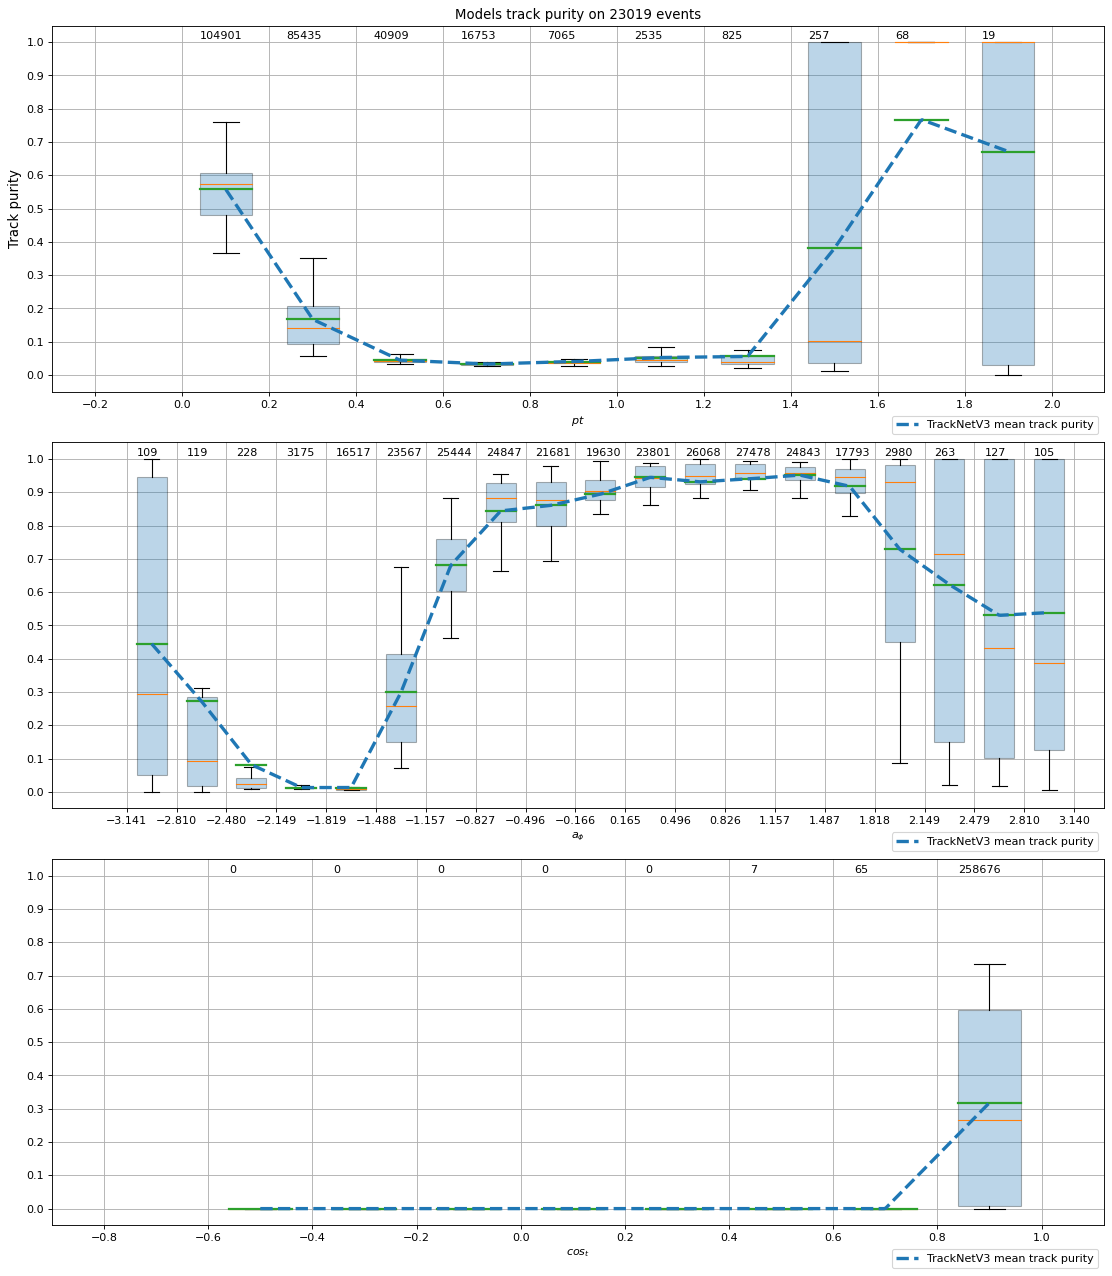

In [55]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_precision)

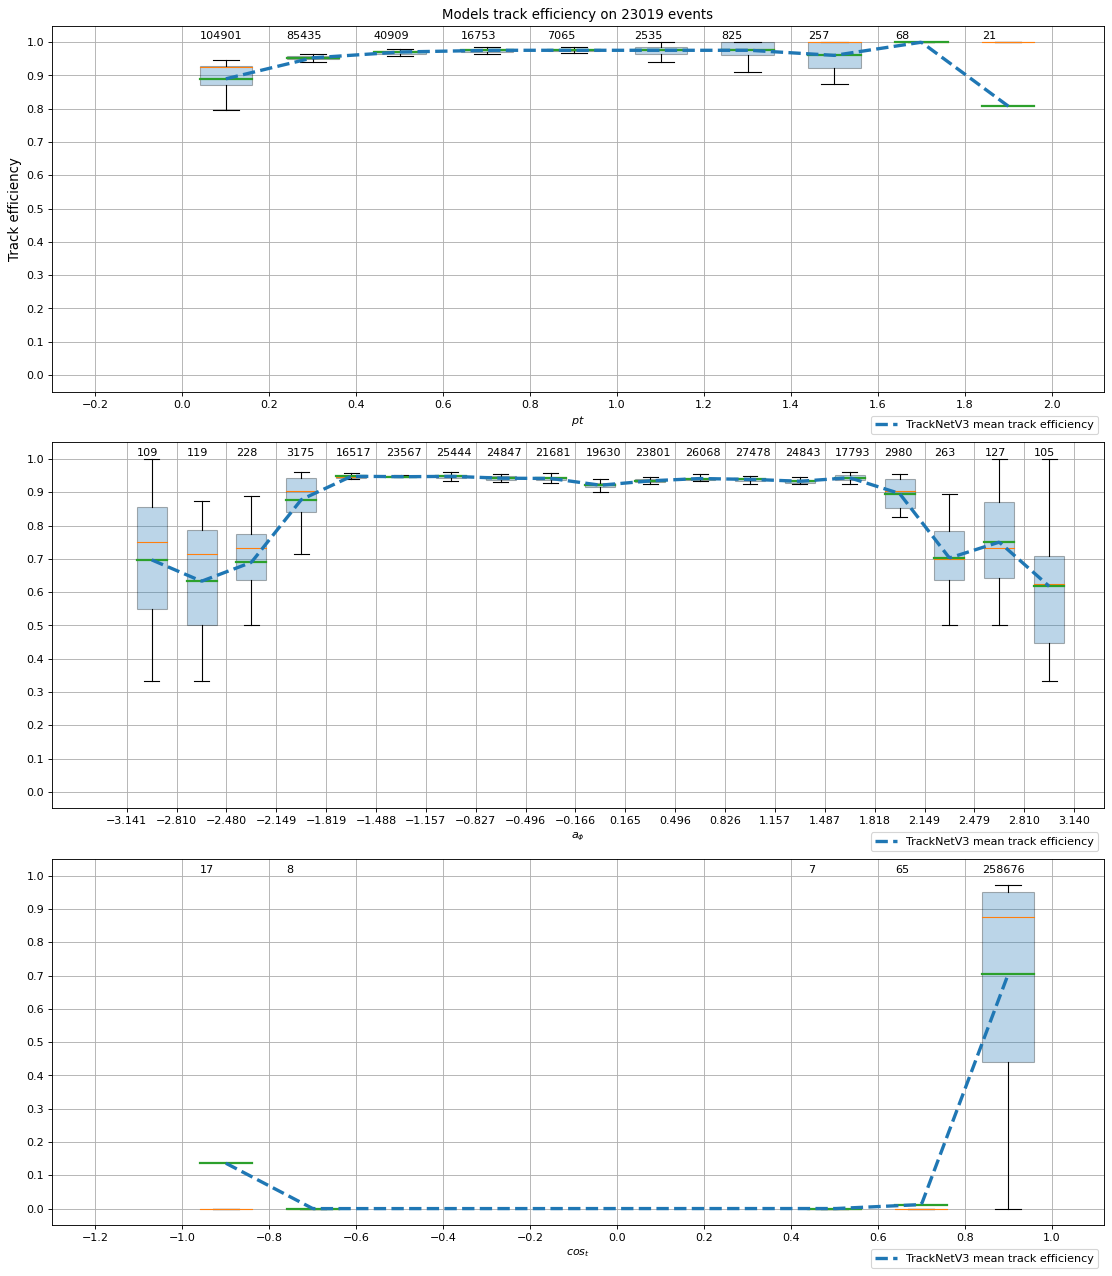

In [56]:
plot_model_results(["TrackNetV3"],
                   [results_tracknet],
                   to_recall)

In [ ]:
xs = []
for ev in res_1:
    if len(ev) > 0:
        for cand in ev:
            xs.append(cand.detach().numpy())
len(xs)

In [ ]:
ys = []
for event_cands in res_2:
    if len(event_cands) > 0:
        ys.append(pd.merge(event_cands, results_tracknet[0].query('event_id == @event_cands.event.iloc[0]'), 'left', on=STATION_COLUMNS).fillna(0).pred > 0)
ys = [y.values for y in ys]
labels = []
for ev in ys:
    for cand in ev:
        labels.append(cand)
labels = np.array(labels)
len(labels)

In [ ]:
np.unique(labels, return_counts=True)

In [ ]:
xs_two = xs
labels_two = labels

In [ ]:
res_1 = []
res_2 = []

In [ ]:
parse_cfg = {
    'csv_params' : {
        "sep": '\s+',
        "encoding": 'utf-8',
        "names": ['event',  'x', 'y', 'z', 'det','station', 'track', 'px', 'py', 'pz', 'vx', 'vy', 'vz']
    },
    'input_file_mask':f'/zfs/store5.hydra.local/user/p/pgonchar/data/bmn/run7/events/simdata_ArPb_3.2AGeV_mb_43.txt',
    'events_quantity':':'
}

In [ ]:
evaluator = EventEvaluator(parse_cfg, global_transformer, N_STATIONS)
events = evaluator.prepare(model_loader=TrackNetModelLoader())[0]
all_results = evaluator.build_all_tracks()
model_results = evaluator.run_model(preprocess_one_event, run_tracknet_eval)
start_time = time.time()
results_tracknet = evaluator.solve_results(model_results, all_results, match_percentage=0.7)
end_time = time.time()
print(f'solving took {end_time - start_time} seconds')

In [ ]:
xs = []
for ev in res_1:
    if len(ev) > 0:
        for cand in ev:
            xs.append(cand.detach().numpy())
len(xs)

In [ ]:
ys = []
for event_cands in res_2:
    if len(event_cands) > 0:
        ys.append(pd.merge(event_cands, results_tracknet[0].query('event_id == @event_cands.event_id.iloc[0]'), 'left', on=STATION_COLUMNS).fillna(1).pred > 0)
ys = [y.values for y in ys]
labels = []
for ev in ys:
    for cand in ev:
        labels.append(cand)
labels = np.array(labels)
len(labels)

In [ ]:
xs = xs_two + xs
len(xs)

In [ ]:
labels = np.append(labels_two, labels)
len(labels)

In [ ]:
data = [xs, labels]
np.save('../output/selector_train/train_2000_42_beforegraph.npy', data)

In [ ]:
for x in xs:
    x[:, :, 12][x[:, :, 12] == 0] += 1e-9

In [ ]:
xs_old = xs

In [ ]:
for tr_len in np.unique(tracks.len):
    cands = tracks.query('len == @tr_len')
    print(f'tracklen = {tr_len}, number = {len(cands)}, relative = {round(len(cands) / len(tracks), 3)}, with holes = {round(len(cands[cands.with_holes > 0]) / len(cands), 3)}')
print(f'overall with holes = {round(len(tracks[tracks.with_holes > 0]) / len(tracks), 3)}')
print(f'tracks with no hit on first station = {round(len(tracks[tracks.hit_id_0 == -1]) / len(tracks), 3)}')
for num_holes, count in zip(*np.unique(tracks.with_holes, return_counts=True)):
    print(f'tracks with {num_holes} holes = {round(count / len(tracks), 3)}')

In [46]:
def draw_single(X, Ri, Ro, y, c_true = 'green', c_fake = (0,0,0,0.1), xcord1 = (2, 'x'), xcord2 = (1, 'y'), ycord=(0, 'z'), draw_fake=True):
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    #                0    1  2  3  4  5
    # Draw the hits (r, phi, z, x, y, z)
    # colMap = np.zeros_like(X)
    # colMap[:, 0] = X[:, 0]*1.7 + 100
    # colMap *= 1.0 / colMap.max()
    ax0.scatter(X[:, xcord1[0]],
                X[:, ycord[0]], c='black')
    ax1.scatter(X[:, xcord2[0]],
                X[:, ycord[0]], c='black')

    # Draw the segments
    for j in range(y.shape[0]):
        ax0.plot([feats_o[j, xcord1[0]], feats_i[j, xcord1[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
        ax1.plot([feats_o[j, xcord2[0]], feats_i[j, xcord2[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
    # Adjust axes
    ax0.set_xlabel('$%s$' % xcord1[1])
    ax0.set_ylabel('$%s$' % ycord[1])

    ax1.set_xlabel('$%s$' % xcord2[1])
    ax1.set_ylabel('$%s$' % ycord[1])
    plt.tight_layout()
    plt.show()

In [ ]:
for event_id in range(0, 50):
    print(f'event {event_id}:', len(result.query('event_id == @event_id and pred == -1')))

In [175]:
for event_id in [0]:# range(1100, 1200):
    print(event_id)
    X, Ri, Ro, y = tracknet_event_to_graph(events.query('event == @event_id'), result.query('event_id == @event_id'))[0]
    draw_single(X, Ri, Ro, y,c_true=(0, 1, 0, 1), c_fake=(1,0,0,0.5), xcord1=(0, 'x'), xcord2=(1, 'y'), ycord=(2, 'z'))
    #plt.savefig(f'output_{event_id}.jpg', dpi=300)

0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
one_event_result = results_tracknet[0].query('event_id == @event_id')
one_event_result

In [ ]:
events_xyz = events[['x', 'y', 'z']].copy()
events_values = events_xyz.set_index(events.index_old).sort_index().values

x_data = []
y_data = []
z_data = []
results_candidates = results_tracknet[0][STATION_COLUMNS]
for track_candidate in tqdm(results_candidates.itertuples(index=False, name=None), total=len(results_candidates)):
    track_candidate = np.array(track_candidate, dtype=int)
    track_candidate = track_candidate[track_candidate >= 0]
    #coords = events_xyz.loc[track_candidate].values
    coords = events_values[track_candidate]

    x_data.append(coords[:, 0])
    y_data.append(coords[:, 1])
    z_data.append(coords[:, 2])

In [ ]:
len(x_data)

In [ ]:
labels = results_tracknet[0].pred
event_ids = results_tracknet[0].event_id

In [ ]:
len(x_data), len(y_data), len(z_data), len(labels), len(event_ids)

In [ ]:
labels.value_counts()

In [ ]:
def draw_track(ax, x, y, z, label, track_num):
    if label == 1:
        col = (0., 1.0, 0.000, 0.9)
    elif label == 0:
        col = (0, 0.0, 1, 0.9)
    elif label == -1:
        pass
        col = (1, 0.0, 0.000, 0.9)
    else:
        col = (0, 1, 0, 0.3)
    val_x = x#track[:,0]
    val_y = y#track[:,2]
    val_z = z#track[:,1# ]
    #if track_num != 22 and track_num != 1285:
    #    col = list(col)[:3] + [0]
    line, = ax.plot(val_x, val_y, zs=val_z, color=col, label=f'track_num={track_num}', picker=10)
    #ax.scatter(val_x, val_y, zs=val_z, color=col)
    return line

In [ ]:
%matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def draw_event(ev_id, events_df, projection, draw_unproc=False):
    fig = plt.figure(figsize=(12,12))
    ax = Axes3D(fig) # Method 1
    ax.set_zlabel('Z')
    if projection == 'xz':
        ax.view_init(azim=270, elev=0)
        ax.set_xlabel('X')
    else:
        ax.view_init(azim=360, elev=0)
        ax.set_ylabel('Y')
    i = 0
    lines = []

    #hits_real = events_df[~events_df.px.isna()].query('event == @ev_id')
    #ax.scatter(hits_real['x'], hits_real['y'], zs=hits_real['z'], c='green')

    hits_virtual = events_df[events_df.px.isna()].query('event == @ev_id')
    ax.scatter(hits_virtual['x'], hits_virtual['y'], zs=hits_virtual['z'], c='red')

    if draw_unproc:
        for tr_id, df in events_df.query('event == @ev_id').groupby('track'):
            if tr_id != -1:
                lines.append(draw_track(ax, df.x, df.y, df.z, 2, tr_id))


    for x, y, z, label, event in zip(x_data, y_data, z_data, labels, event_ids):
        if event == ev_id:# and len(x) < 7:
            lines.append(draw_track(ax, x, y, z, label, i))
        i+=1
    leg = ax.legend(fancybox=True, shadow=True)
    lined = {}  # Will map legend lines to original lines.
    for legline, origline in zip(leg.get_lines(), lines):
        legline.set_picker(True)  # Enable picking on the legend line.
        lined[legline] = origline

    def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)
        # Change the alpha on the line in the legend so we can see what lines
        # have been toggled.
        legline.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()

    fig.canvas.mpl_connect('pick_event', on_pick)
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
n_event = 2
for n_event in range(10):
    if len(results_tracknet[0].query('event_id == @n_event and pred == 0')) != 0:
        print(n_event)
        draw_event(n_event, events, 'xz')

In [ ]:
n_event = 2
draw_event(n_event, events1, 'xz', draw_unproc=True)

In [ ]:
x_data[1285]

In [ ]:
tr = events1.query('event == 2 and track == 22')
tr

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
for i in range(9):
    ax.plot(tr.x[, val_y, zs=val_z, color=col, label=f'track_num={track_num}', picker=10)


In [ ]:
global_transformer1 = Compose([
    FixStationsBMN(),
    DropShort(num_stations=4),
    DropSpinningTracks(),
    BakeStationValues(values=z_values),
    ConstraintsNormalize(constraints=constraints),])

In [ ]:
N_STATIONS = 9

In [ ]:
evaluator1 = EventEvaluator(parse_cfg, global_transformer1, N_STATIONS)
events1 = evaluator1.prepare(model_loader=TrackNetModelLoader())[0]

In [ ]:
len(list(events1.groupby(['track', 'event'])))

In [ ]:
(len(list(events1.groupby(['track', 'event']))) - len(list(events.groupby(['track', 'event'])))) / len(list(events1.groupby(['track', 'event'])))